<a href="https://colab.research.google.com/github/meiruv/NIPS-Papers-Analysis/blob/main/Nips_Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Taking a go on this dataset:
https://www.kaggle.com/rowhitswami/nips-papers-1987-2019-updated/tasks?taskId=2960

The task here is to model the topic of each NIPS paper using LDA and evaluate the results independently. I will try modelling with LDA and with BERT as proposed here: https://github.com/MaartenGr/BERTopic

I will need to check if I the abstracts are enough for the modelling or if the full text should be used.
I will want to check if the author's name can somehow be used for validation (if I know an author is an expert of one field and the paper is classified under another topic I might suspect the classification is wrong)

In [5]:
# ! python -m spacy download en_core_web_lg


# Fetching the Data From Kaggle

In [6]:
! pip install -q kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:
! cp kaggle.json ~/.kaggle/
! kaggle datasets download -d rowhitswami/nips-papers-1987-2019-updated

 93% 99.0M/106M [00:00<00:00, 105MB/s] 
100% 106M/106M [00:00<00:00, 115MB/s] 


In [8]:
import os
import zipfile

local_zip = 'nips-papers-1987-2019-updated.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('nips_papers')
zip_ref.close()

In [9]:
!ls nips_papers

authors.csv  papers.csv


# Exploratory Analysis 

In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

## Authors

In [11]:
authors_df = pd.read_csv('nips_papers/authors.csv')
print('Authors df Shape : ',authors_df.shape)
authors_df.head()

Authors df Shape :  (30237, 4)


,source_id,first_name,last_name,institution
0,27,Alan,Murray,NaN
1,27,Anthony,Smith,NaN
2,27,Zoe,Butler,NaN
3,63,Yaser,Abu-Mostafa,NaN
4,60,Michael,Fleisher,NaN


In [12]:
len(authors_df['institution'].unique())

2672

In [13]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~ need to not count all writers as different publications! group by the institution and count distinct source_id  ~~~~~~~~~~~~~~~~~~~~~~~~~~~

insts_and_pubs = pd.DataFrame(authors_df['institution'].value_counts()).reset_index()
insts_and_pubs.columns = ['institution', 'Publications']
insts_and_pubs.head(60)

,institution,Publications
0,Stanford University,542
1,MIT,464
2,Carnegie Mellon University,446
3,UC Berkeley,404
4,Google,342
5,Microsoft Research,298
6,DeepMind,269
7,Princeton University,256
8,Duke University,230
9,Columbia University,221


Text(0.5, 0, '# Publications Since 1987)')

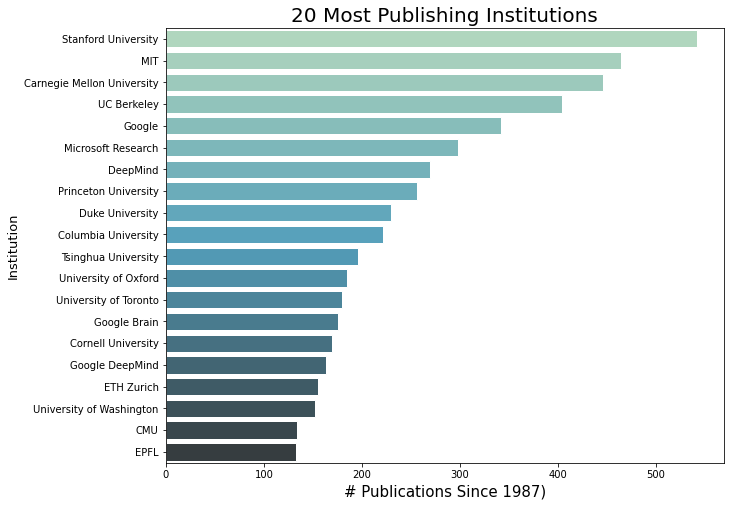

In [14]:
a4_dims = (10, 8)
fig, ax = plt.subplots(figsize=a4_dims)

sns.set(style = "darkgrid", font_scale=1.3)
ax = sns.barplot(x='Publications', y="institution", data=insts_and_pubs.head(20) , palette = "GnBu_d")
ax.axes.set_title("20 Most Publishing Institutions",fontsize=20)
ax.set_ylabel("Institution",fontsize=13)
ax.set_xlabel("# Publications Since 1987)",fontsize=15)
#ax.set_xticklabels(top_diff_30['Country'],rotation = 45, ha="right")

# fig.savefig('Biggeat_Leap_Sine_2000_Horizontal.jpg')

I found it interesting to look at how many papers each institution published and compare all institutions to find top publishers. This list is limited though because some institutiona and spelled differently-for example MIT appears sometimes as MIT and sometimes as Massachusetts Institute of Technology - row 23, if we combine the amounts on those rows we get more than Stanford which means MIT is the world's leading institution in terms of publications since 1987. Another example is Google having several rows - one for brain, one for deepminds, etc. If we combine those rows it will probably be ranked higher in this table.
Also - fun fact and a bit of pride for Israelis - the Technion is 31st in this list, which reminds us yet again that while such rankings can be calculated by absolute numbers it is more accurate to normalize them based on the institution's size and perhaps bring into the equation its amounts of funding.

It would be interesting to see how many institutions got into this list from each country/continent as well as how many of them are GAMFA and corporates in general. I didn't find an easy way for calculating this so I skipped this idea for the time being.

In [15]:
# Writers per Paper distribution

writers_per_paper_df = pd.DataFrame(authors_df['source_id'].value_counts()).reset_index()
writers_per_paper_df.columns = ['source_id','n_writers']
writers_per_paper_df.head(60)

,source_id,n_writers
0,1048,31
1,717,30
2,1442,30
3,2889,29
4,186,28
5,1143,28
6,1344,27
7,758,26
8,354,26
9,146,26


In [16]:
writers_per_paper_df[writers_per_paper_df['n_writers']>=10].shape[0] - 80

948

In [17]:
writers_per_paper_df.shape

(4522, 2)

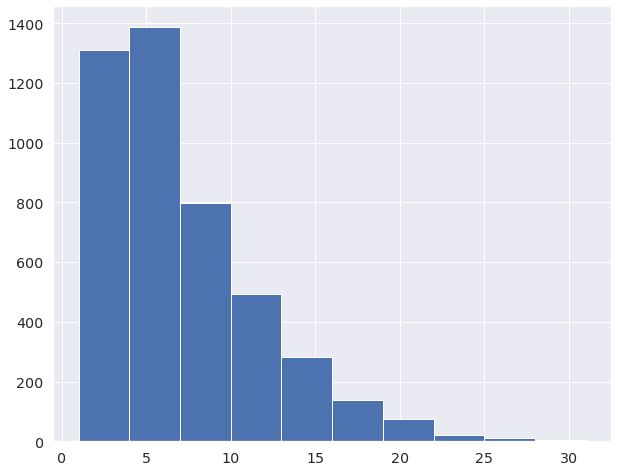

In [18]:
writers_per_paper_df['n_writers'].hist(figsize = (10,8));

There are 4522 papers in this dataset, out of which 80 had 20 authors or more. 
948 has between 10-20 authors and the rest (3494) had less than 10 authors.



In [ ]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ same distribution but per institution - avtala smuya ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [19]:
4522 - 80 - 948

3494

In [20]:
# Papers per author distribution
authors_df['author'] = authors_df['first_name']+' ' + authors_df['last_name']

In [21]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ use groupby instead of value counts ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

apers_per_author_df = pd.DataFrame(authors_df['author'].value_counts()).reset_index()
papers_per_author_df.columns = ['author','n_publications']
papers_per_author_df.head()

,author,n_publications
0,Michael Jordan,111
1,Yoshua Bengio,74
2,Bernhard Schölkopf,69
3,Geoffrey Hinton,63
4,Francis Bach,59


My conclusion from this is to name my child Michael Jordan

```
`# This is formatted as code`
```



In [22]:
# special request from a friend
papers_per_author_df[papers_per_author_df['author']=='Beatrice Golomb']



,author,n_publications
9648,Beatrice Golomb,1


In [23]:
# Another way to query this, I find it useful to keep such snippets
papers_per_author_df.loc[papers_per_author_df['author'].str.startswith('Bea', na=False)]

,author,n_publications
8608,Beat Buesser,1
9009,Beata Jarosiewicz,1
9648,Beatrice Golomb,1
12811,Beat Pfister,1
13963,Beat Flepp,1



 ### Are there communities here?

Draw a graph from this data. the most basic way will be to draw an edge between each authors that published together and weight the edges based on the amount of publications they have together, then run community detection algorithm and see if there are any. also see top publishers and perhaps place the authors on a map based on their institution to see where those communities occur.

In [24]:
authors_df.head()

,source_id,first_name,last_name,institution,author
0,27,Alan,Murray,NaN,Alan Murray
1,27,Anthony,Smith,NaN,Anthony Smith
2,27,Zoe,Butler,NaN,Zoe Butler
3,63,Yaser,Abu-Mostafa,NaN,Yaser Abu-Mostafa
4,60,Michael,Fleisher,NaN,Michael Fleisher


In [25]:
author_and_paper_df = authors_df[['source_id','author']]
author_and_paper_df.head()

,source_id,author
0,27,Alan Murray
1,27,Anthony Smith
2,27,Zoe Butler
3,63,Yaser Abu-Mostafa
4,60,Michael Fleisher


In [26]:
co_authors_df = author_and_paper_df.merge(author_and_paper_df, how = 'outer', on = 'source_id')
co_authors_df_clear_1 = co_authors_df[co_authors_df['author_x']!=co_authors_df['author_y']]
co_authors_df_clear_1.head(20)

,source_id,author_x,author_y
1,27,Alan Murray,Anthony Smith
2,27,Alan Murray,Zoe Butler
3,27,Alan Murray,Huitong Qiu
4,27,Alan Murray,Fang Han
5,27,Alan Murray,Han Liu
6,27,Alan Murray,Brian Caffo
7,27,Anthony Smith,Alan Murray
9,27,Anthony Smith,Zoe Butler
10,27,Anthony Smith,Huitong Qiu
11,27,Anthony Smith,Fang Han


In [27]:
co_authors_df_clear_1['author_x'] = co_authors_df_clear_1['author_x'].astype(str)
co_authors_df_clear_1['author_y'] = co_authors_df_clear_1['author_y'].astype(str)

co_authors_df_clear_1['check_string'] = co_authors_df_clear_1.apply(lambda row: ''.join(sorted([row['author_x'], row['author_y']])), axis=1)
co_authors_df_clear = co_authors_df_clear_1.drop_duplicates(subset=['check_string','source_id']).drop(columns = ['check_string','source_id'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [28]:
co_authors_df_clear

,author_x,author_y
1,Alan Murray,Anthony Smith
2,Alan Murray,Zoe Butler
3,Alan Murray,Huitong Qiu
4,Alan Murray,Fang Han
5,Alan Murray,Han Liu
...,...,...
297852,Manish Purohit,Erik Vee
297853,Manish Purohit,Joshua Wang
297857,Zoya Svitkina,Erik Vee
297858,Zoya Svitkina,Joshua Wang


In [29]:
co_authors_df_clear.groupby(['author_x','author_y']).size()

author_x        author_y         
A C Tsoi        A Sergejew           1
                Alex Smola           1
                Arthur Gretton       1
                D S C So             1
                Daniel Lowd          1
                                    ..
Łukasz Struski  Bartosz Zieliński    1
                Benjamin Van Roy     1
                Jacek Tabor          1
                Przemysław Spurek    1
                Xiuyuan Lu           1
Length: 127637, dtype: int64

In [30]:
n_colaborations_per_pair_df = pd.DataFrame(co_authors_df_clear.groupby(['author_x','author_y']).size()).reset_index()
n_colaborations_per_pair_df.columns = ['author_x','author_y','n_colaborations']
n_colaborations_per_pair_df

,author_x,author_y,n_colaborations
0,A C Tsoi,A Sergejew,1
1,A C Tsoi,Alex Smola,1
2,A C Tsoi,Arthur Gretton,1
3,A C Tsoi,D S C So,1
4,A C Tsoi,Daniel Lowd,1
...,...,...,...
127632,Łukasz Struski,Bartosz Zieliński,1
127633,Łukasz Struski,Benjamin Van Roy,1
127634,Łukasz Struski,Jacek Tabor,1
127635,Łukasz Struski,Przemysław Spurek,1


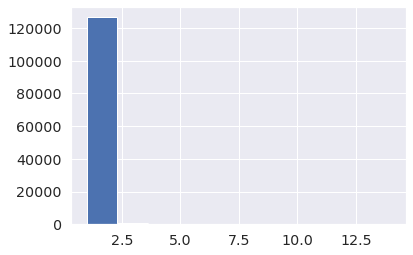

In [31]:
n_colaborations_per_pair_df['n_colaborations'].hist()

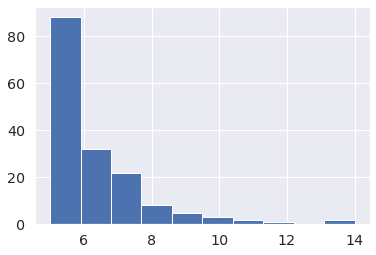

In [32]:
n_colaborations_per_pair_df[n_colaborations_per_pair_df['n_colaborations']>4]['n_colaborations'].hist()

In [33]:
n_colaborations_per_pair_df.to_csv('nips_co_authors_and_colaborations.csv')

### Making graph of co authors


In [34]:
import networkx as nx

In [35]:
G = nx.from_pandas_edgelist(n_colaborations_per_pair_df, 'author_x', 'author_y', ['n_colaborations'])

In [ ]:

#  authors charecteristics - institution, years of publishing, topic they research. cluster writers based on NLP and other results from the analysisand draw map based on cosine similarity
#  and then project to employees. 

In [52]:
# time series per writer and per institution - who emerged in the past few years? who faded? who only published once? etc, perhaps divide to 5 years

This turns out to have far more interesting options than the one I considered so I will do graph analysis on this on a separate notebook.



## Papers

In [36]:
papers_df = pd.read_csv('nips_papers/papers.csv')
papers_df.head()

,source_id,year,title,abstract,full_text
0,27,1987,Bit-Serial Neural Networks,NaN,573 \n\nBIT - SERIAL NEURAL NETWORKS \n\nAlan...
1,63,1987,Connectivity Versus Entropy,NaN,1 \n\nCONNECTIVITY VERSUS ENTROPY \n\nYaser S...
2,60,1987,The Hopfield Model with Multi-Level Neurons,NaN,278 \n\nTHE HOPFIELD MODEL WITH MUL TI-LEVEL N...
3,59,1987,How Neural Nets Work,NaN,442 \n\nAlan Lapedes \nRobert Farber \n\nThe...
4,69,1987,Spatial Organization of Neural Networks: A Pro...,NaN,740 \n\nSPATIAL ORGANIZATION OF NEURAL NEn...


In [37]:
# papers per year bar plot
papers_per_year_df = pd.DataFrame(papers_df['year'].value_counts()).reset_index()
papers_per_year_df.columns = ['year','count']

papers_per_year_df.head()

,year,count
0,2019,1428
1,2018,1009
2,2017,679
3,2016,569
4,2014,411


In [38]:
papers_per_year_df_sorted = papers_per_year_df.sort_values(by = 'year',ascending=True)

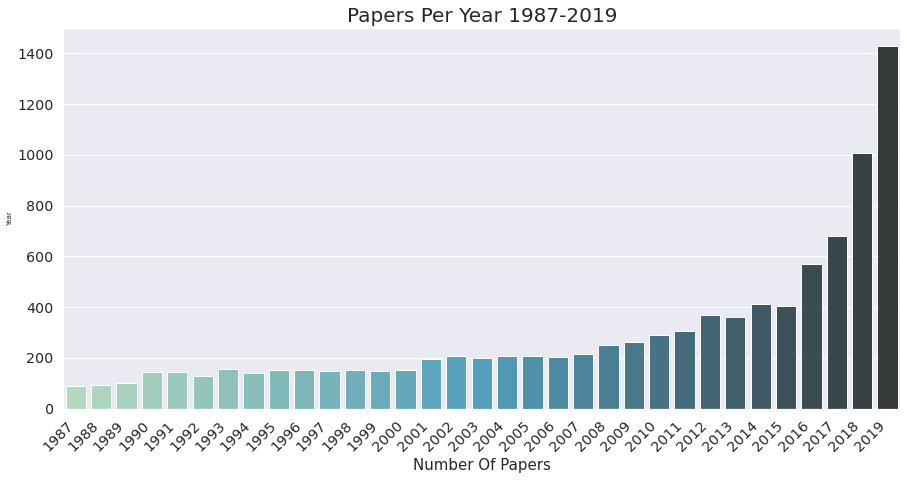

In [39]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)

sns.set(style = "darkgrid", font_scale=1.3)
ax = sns.barplot(x="year", y="count", data = papers_per_year_df_sorted , palette = "GnBu_d")
ax.axes.set_title("Papers Per Year 1987-2019",fontsize=20)
ax.set_ylabel("Year",fontsize=7)
ax.set_xlabel("Number Of Papers",fontsize=15)
ax.set_xticklabels(papers_per_year_df_sorted['year'],rotation = 45, ha="right");


*   tf - idf on the titles and then sum per year/ decade/ half-decades
*   same on abstracts
*   same on papers.
*   keywors extraction and comparison between years, looking for timely trends, etc.

In [40]:
papers_df['title'].head(60)

0                            Bit-Serial Neural Networks
1                           Connectivity Versus Entropy
2           The Hopfield Model with Multi-Level Neurons
3                                  How Neural Nets Work
4     Spatial Organization of Neural Networks: A Pro...
5     A Neural-Network Solution to the Concentrator ...
6                LEARNING BY STATE RECURRENCE DETECTION
7                 Stability Results for Neural Networks
8     Introduction to a System for Implementing Neur...
9     Optimization with Artificial Neural Network Sy...
10                  Optimal Neural Spike Classification
11                       REFLEXIVE ASSOCIATIVE MEMORIES
12    The Performance of Convex Set Projection Based...
13      Speech Recognition Experiments with Perceptrons
14    On Properties of Networks of Neuron-Like Elements
15    Ensemble' Boltzmann Units have Collective Comp...
16         On Tropistic Processing and Its Applications
17    Neuromorphic Networks Based on Sparse Opti

In [41]:
papers_df['full_text'][0]

'573 \n\nBIT - SERIAL NEURAL  NETWORKS \n\nAlan F.  Murray,  Anthony V . W.  Smith  and Zoe F.  Butler. \n\nDepartment of Electrical Engineering,  University of Edinburgh, \n\nThe King\'s Buildings, Mayfield Road,  Edinburgh, \n\nScotland,  EH93JL. \n\nABSTRACT \n\nA  bit  - serial  VLSI  neural  network  is  described  from  an  initial  architecture  for  a \nsynapse array through to silicon layout and board design.  The issues surrounding bit \n- serial  computation,  and  analog/digital  arithmetic  are  discussed  and  the  parallel \ndevelopment  of  a  hybrid  analog/digital  neural  network  is  outlined.  Learning  and \nrecall  capabilities  are  reported  for  the  bit  - serial  network  along  with  a  projected \nspecification  for  a  64  - neuron,  bit  - serial  board  operating  at 20 MHz.  This tech(cid:173)\nnique  is  extended  to  a  256  (2562  synapses)  network  with  an  update  time  of 3ms, \nusing  a  "paging"  technique  to  time  - multiplex  calculations

# Text Analysis

## Preprocessing

In [42]:
import re

def clean_text(text):
    """Doc cleaning"""
    
    # Lowering text
    text = text.lower()
    
    # Removing punctuation
    text = "".join([c for c in text if c not in PUNCTUATION])
    
    # Removing whitespace and newlines
    text = re.sub('\s+',' ',text)
    
    return text



In [43]:
PUNCTUATION = """!"#$%&'()*+,-/:;<=>?@[\]^_`{|}~""" # excluding . (full-stop) from the set of punctuations


In [44]:
papers_df.shape

(9680, 5)

In [45]:
papers_df.dropna(subset=['full_text'], inplace=True)
papers_df.shape

(9677, 5)

In [46]:
papers_df['full_text_clean'] = papers_df['full_text'].apply(lambda row: clean_text(row))

In [47]:
papers_df['full_text_clean'][3]

'442 alan lapedes robert farber theoretical division how neural nets work los alamos national laboratory los alamos nm 87545 abstract there is presently great interest in the abilities of neural networks to mimic qualitative reasoning by manipulating neural incodings of symbols. less work has been performed on using neural networks to process floating point numbers and it is sometimes stated that neural networks are somehow inherently inaccucid173 rate and therefore best suited for fuzzy qualitative reasoning. nevertheless the potential speed of massively parallel operations make neural net number crunching an interesting topic to explore. in this paper we discuss some of our work in which we demonstrate that for certain applications neural networks can achieve significantly higher numerical accuracy than more conventional techcid173 niques. in particular prediction of future values of a chaotic time series can be performed with exceptionally high accuracy. we analyze how a neural net 

## LDA

In [48]:
from gensim.corpora import Dictionary

texts = papers_df['full_text_clean']

dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

import numpy
numpy.random.seed(1) # setting random seed to get the same results each time.

from gensim.models import ldamodel
model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=10, minimum_probability=1e-8)
model.show_topics()

TypeError: ignored

## Another Way to LDA 
How do you feel about this rime?

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.9, min_df=2, stop_words='english', token_pattern=r'(?u)\b[A-Za-z]+\b')
papers_tf_idf = tfidf.fit_transform(papers_df['full_text_clean'])

papers_tf_idf

<9677x122023 sparse matrix of type '<class 'numpy.float64'>'
	with 8250043 stored elements in Compressed Sparse Row format>

In [50]:
from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(n_components=15, random_state=101)

# This can take a while, we are dealing with large number of documents here
LDA.fit(papers_tf_idf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=15, n_jobs=None,
                          perp_tol=0.1, random_state=101, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [51]:
# What topics did we get?

for index, topic in enumerate(LDA.components_):
    print(f"THE TOP 15 WORDS FOR TOPIC #{index}")
    list_keywords = [tfidf.get_feature_names()[index] for index in topic.argsort()[-10:]]
    print(list_keywords)
    print("\n")

THE TOP 15 WORDS FOR TOPIC #0
['kary', 'pcn', 'gpn', 'spore', 'ifo', 'epca', 'uoi', 'fascicles', 'qrouting', 'zsl']


THE TOP 15 WORDS FOR TOPIC #1
['cann', 'sagald', 'pbil', 'endmembers', 'ifat', 'ihmm', 'bicluster', 'dpsgd', 'sgr', 'sbp']


THE TOP 15 WORDS FOR TOPIC #2
['lpa', 'pux', 'tensorsketch', 'sonn', 'bisimulation', 'ebnn', 'idc', 'nofm', 'dvae', 'cvar']


THE TOP 15 WORDS FOR TOPIC #3
['disaggregation', 'bidder', 'buyers', 'revenue', 'gpr', 'auction', 'auctions', 'coalescent', 'sghmc', 'seller']


THE TOP 15 WORDS FOR TOPIC #4
['forgeries', 'houdini', 'vamp', 'hca', 'qbc', 'gpomdp', 'bbvi', 'ggp', 'rivalry', 'foba']


THE TOP 15 WORDS FOR TOPIC #5
['multibatch', 'asvm', 'wnll', 'pcsa', 'strf', 'twf', 'nettrim', 'kanji', 'nsm', 'mwis']


THE TOP 15 WORDS FOR TOPIC #6
['tlasso', 'hnn', 'parsec', 'icn', 'hots', 'shareboost', 'coda', 'metaclass', 'rgd', 'ksupport']


THE TOP 15 WORDS FOR TOPIC #7
['avgm', 'dpca', 'hyperq', 'sco', 'ktf', 'nao', 'rsnns', 'ydox', 'dcnns', 'lta']




### Drawing a Heatmap of the world with colors based on amounts of publications per country.

For that I will need to know the location of the authors of each paper. I can either draw that from each paper (in the end of the authors' list appears the institution and its address), I can extract the location using Spacy or another method. OR I can get each institution from the writers' list, fetch its address via Google API and merge it with the papers table to find amounts per country and then plot it.

In [ ]:
# Checking if I can fetch the institution's location using Spacy. Then I can plot a heat map of the world with number of publication per each location,
# I'm also curious to see how many publishers are from outside the U.S and Europe.

import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()

gpe = [] # countries, cities, states
loc = [] # non gpe locations, mountain ranges, bodies of water

city1 = []
country1 = []

for i in range(10):
  gpe = []
  doc = nlp(papers_df['full_text'][i])
  for ent in doc.ents:
      if (ent.label_ == 'GPE'):
          gpe.append(ent.text)
  print('---------- Iteration Number ',i)
  print(gpe)
  city1.append(gpe[0])
  country1.append(gpe[1])





In [53]:
i = 7
papers_df['full_text'][i]

'554 \n\nSTABILITY RESULTS  FOR NEURAL  NETWORKS \n\nA.  N.  Michell, J. A.  FarreUi  , and W.  Porod2 \n\nDepartment of Electrical and  Computer Engineering \n\nUniversity of Notre  Dame \n\nNotre Dame, IN 46556 \n\nABSTRACT \n\nIn the present paper we survey and utilize results from the qualitative theory of large \nscale interconnected dynamical systems in order to develop  a  qualitative theory for  the \nHopfield model of neural networks.  In our approach we  view such networks as  an inter(cid:173)\nconnection of many single neurons.  Our results  are  phrased in  terms of the  qualitative \nproperties of the individual neurons and in terms of the properties of the interconnecting \nstructure of the neural  networks.  Aspects of neural networks which  we  address include \nasymptotic stability,  exponential stability,  and instability  of an  equilibrium;  estimates \nof trajectory bounds; estimates of the domain of attraction of an asymptotically stable \nequilibrium;  and stabi

In [ ]:
import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()

gpe = [] # countries, cities, states

city2 = []
country2 = []

for i in range(10):
  gpe = []
  doc = nlp(papers_df['full_text'][i].lower().split('abstract')[0].replace('\n',''))
  for ent in doc.ents:
      if (ent.label_ == 'GPE'):
          gpe.append(ent.text)
  print('---------- Iteration Number ',i)
  print(gpe)





In [ ]:
papers_df['full_text'][i].lower()

In [ ]:
i = 3
papers_df['full_text'][i].lower().split('abstract')[0].replace('\n','')

In [ ]:
papers_df['full_text'][i].lower().split('abstract')[0]

In [ ]:
papers_df['full_text'][i]